# Tutorial: Maximum Cut via Quantum Imaginary Time Evolution (QITE)
## By: Willie Aboumrad, Senior Quantum Applications Scientist at IonQ

Quantum computers are poised to solve problems that are currently intractable,
and IonQ is leading the way. In this tutorial, we demonstrate how to leverage
[IonQ Forte][1]'s industry-leading capabilities to solve instances of the
[NP-hard][2] combinatorial optimization problem with many wide-ranging applications known as
[Maximum Cut (MaxCut)][3] using a
[novel Variational Quantum Imaginary Time Evolution (varQITE)][4] algorithm
developed by IonQ in conjunction with researchers at Oak Ridge National Labs
(ORNL).


[1]: https://ionq.com/forte
[2]: https://en.wikipedia.org/wiki/NP-hardness
[3]: https://en.wikipedia.org/wiki/Maximum_cut
[4]: https://arxiv.org/pdf/2404.16135


In this challenge, you will learn to:
1. **Understand the MaxCut problem** and its significance in various real-world contexts.
2. **Formulate MaxCut as a Hamiltonian minimization problem**, bridging classical combinatorial optimization with quantum computation.
3. **Explore the concept of Quantum Imaginary Time Evolution (QITE) and the varQITE algorithm**, a way to update circuit parameters without a traditional classical optimizer.
4. **Implement varQITE to solve small instances of MaxCut**, running circuits on IonQ’s state-of-the-art hardware or a simulator.

**What you need to know before starting:**
- Basic knowledge of quantum computing concepts: qubits, Pauli matrices, and the computational basis.
- Familiarity with variational quantum algorithms (e.g., VQE, QAOA) is helpful but not strictly required.
- Some understanding of Python and the Qiskit framework.

**Why MaxCut?**  
The MaxCut problem is **NP-hard**, making it computationally difficult for large instances. It is a well-studied problem in theoretical computer science, optimization, and quantum information. From observing how a particular quantum algorithm tackles MaxCut we can get insights into the future of quantum advantage in various optimization tasks.

## Real-World Significance of MaxCut

MaxCut has numerous applications in a variety of fields:

- **VLSI design:** MaxCut helps in partitioning circuit components to minimize signal delay or interference.
- **Social network analysis:** MaxCut can detect communities or clusters by separating heavily connected subgraphs.
- **Image segmentation:** MaxCut-based models can separate an image into different segments for pattern recognition tasks.

References for further reading on MaxCut applications:

# TODO: add some reference links here

MaxCut is a graph problem: given a graph $G = (V, E)$ with vertex set $V$ and
edge set $E$, it asks for a partition of $V$ into sets $S$ and $T$ maximizing
the number of edges crossing between $S$ and $T$.

The code cell below illustrates a simple graph with four vertices and five
edges.


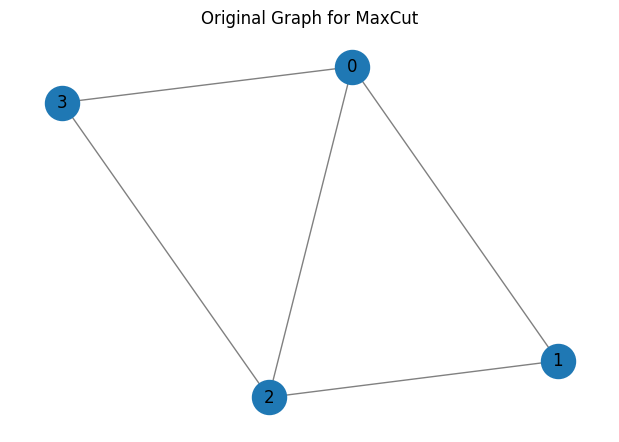

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct your favorite graph using NetworkX
num_nodes = 4
graph = nx.Graph()
graph.add_nodes_from(range(num_nodes))
graph.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)])

# edges = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
# graph = nx.Graph()
# graph.add_edges_from(edges)

pos = nx.spring_layout(graph, seed=42) # reproducible layout
plt.figure(figsize=(6,4))
nx.draw(graph, pos=pos, with_labels=True, node_size=600, edge_color='gray')
plt.title("Original Graph for MaxCut")
plt.show()

# Fix node positions
# pos = nx.spring_layout(graph)
# nx.draw(graph, labels={node: node for node in graph.nodes}, pos=pos)



---



## Formulating the MaxCut Problem

We now use the classical [Quadratic Program (QP)][5] formulation to express MaxCut. Each node $v \in V$ is assigned a binary variable $x_v \in \{0,1\}$, and the objective is to maximize the sum of edges cut by this partition.

**MaxCut QP Formulation:**

$$\text{maximize} \quad \frac{1}{2}\sum_{(i,j)\in E}(x_i - x_j)^2$$

Here, $(x_i - x_j)^2$ equals `1` if the endpoints differ, and `0` otherwise.

We use `docplex` and Qiskit’s optimization module for this step.

[5]: https://en.wikipedia.org/wiki/Quadratic_programming


In [ ]:
import numpy as np
from qiskit_optimization.applications import Maxcut
from docplex.mp.model import Model

# Convert our NetworkX graph to a Maxcut model
maxcut = Maxcut(graph)
qp = maxcut.to_quadratic_program()

print("Quandratic Program:")
print(qp.prettyprint())


Quandratic Program:
Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3





---



## As a Hamiltonian energy minimization problem
### Quantum MaxCut

Quantum computers are good at finding the ground state of particle systems
evolving under the action of a given Hamiltonian. In this section, we'll
construct a Hamiltonian whose energies are exactly the values of the MaxCut
objective function. This correspondence will effectively translate our
classical combinatorial optimization problem into a quantum problem, which
we'll approach using our novel heuristic.

Given an objective function $C(x)$, with domain $x \in \{0, 1\}^n$, we'll
produce a Hamiltonian $H_C$ on $n$ qubits such that
$$
    H_C \ket{x} = C(x) \ket{x}.
$$
In the last equation, $\ket{x}$ denotes the $n$-qubit
[computational basis][10] state indexed by the bit-string $x \in \{0, 1\}$.
Thus the last equation says each of the $2^n$ computational basis states is an
eigenvector of $H_C$, and the eigenvalue corresponding to $\ket{x}$ is $C(x)$;
that is, $H_C$ is diagonal with respect to the computational basis, and its
energies are the values of the objective function $C$.

We'll obtain the Hamiltonian $H_C$ by replacing each $x_j$ in the expression of
$C(x)$ by the operator
$$
    \hat{X}_j \coloneqq \frac{1}{2}(I - Z_j),
$$
where $I$ denotes the identity operator on $n$ qubits and $Z_j$ denotes the
[Pauli-Z][11] operator acting on the $j$th qubit. Notice that $\hat{X}_j$ is
diagonal with respect to the computational basis, and its eigenvalues are zero
and one; in particular,
$$
    \hat{X}_j \ket{x} = x_j \ket{x}.
$$

### MaxCut Hamiltonian

When we apply the Ising map construction to the MaxCut objective
$$
    M(x) = \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$
we obtain the Hamiltonian
$$
    H_M = \sum_{(v, w) \in E} (X_v + X_w - 2 X_v X_w)
    = \frac{1}{2} \sum_{(v, w) \in E} \big(2 I - Z_v - Z_w - (I - Z_v)(I - Z_w)\big)
    = \frac{1}{2}|E| - \frac{1}{2} \sum_{(v, w) \in E} Z_v Z_w.
$$
In the last equation, $|E|$ denotes the number of edges in the graph.

The code cell below illustrates the construction of the MaxCut Hamiltonian, via
the Ising map, corresponding to a simple graph.

[10]: https://en.wikipedia.org/wiki/Qubit#Standard_representation
[11]: https://en.wikipedia.org/wiki/Pauli_matrices

In [ ]:
from qiskit.quantum_info import SparsePauliOp

# Compute the MaxCut Hamiltonian
paulis = [("ZZ", [v, w], -1/2) for v, w in graph.edges]
maxcut_ham = SparsePauliOp.from_sparse_list(paulis, num_qubits=graph.number_of_nodes())
maxcut_ham += 1/2 * graph.number_of_edges() * SparsePauliOp("I" * graph.number_of_nodes())
print("Maxcut Hamiltonian:", maxcut_ham)

Maxcut Hamiltonian: SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII', 'IIII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  2.5+0.j])


## Energy minimization via QITE
### Enter varQITE

With the MaxCut Hamiltonian in hand, we can turn to minimizing its energy using
our [novel quantum-classical varQITE heuristic][1]. Much like any Variataional
Quantum Algorithm (VQA), our novel varQITE method provides a recipe for
iteratively updating the parameters in a variational quantum circuit to
minimize the expectation value of the MaxCut Hamiltonian, measured with respect
to the parametrized state.

A key novelty is that our varQITE algorithm does *not* rely on a classical
optimizer to update the circuit parameters; instead, it specifies an explicit
update rule based on the solution of a system linear Ordinary Differential
Equations (ODEs). The ODEs relate the gradient of the variational circuit
parameters to the expected value of certain operators related to the MaxCut
Hamiltonian, and they are derived from an [Ehrenfest Theorem][3] that applies
to [imaginary time evolution][4]. For details, see Equation (5) in our [varQITE
paper][1].

In any case, setting up the ODE system at each step of the algorithm requires
executing a batch of quantum circuits and running some post-processing to
evaluate the results.

The code cell below illustrates how to set up the variational ansatz
$\ket{\Psi(\theta)}$ introduced by our [varQITE paper][1] in Equation (2).
We'll set up the required circuits and the ODEs further down.

[1]: https://arxiv.org/abs/2404.16135
[2]: https://www.nature.com/articles/s42254-021-00348-9
[3]: https://en.wikipedia.org/wiki/Ehrenfest_theorem
[4]: https://en.wikipedia.org/wiki/Imaginary_time

In [ ]:
pip install pylatexenc

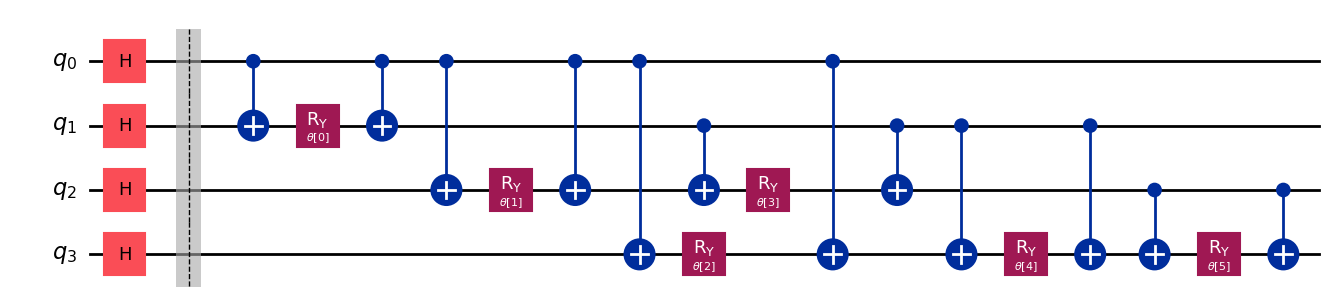

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Construct your favorite ansatz
ansatz = QuantumCircuit(graph.number_of_nodes())

# Use a uniform superposition as the initial state
ansatz.h(range(ansatz.num_qubits))
ansatz.barrier()

# Place entangling gates across qubit pairs that are connected in the graph
complete_graph = nx.complete_graph(graph.number_of_nodes())
params = ParameterVector(r"$\theta$", complete_graph.number_of_edges())
for theta, (u, v) in zip(params, complete_graph.edges):
    ansatz.cx(u, v)
    ansatz.ry(theta, v)
    ansatz.cx(u, v)
ansatz.draw("mpl")

We'll now use our ``ansatz`` to generate all the circuits that are needed to
compute the coefficients in the ODEs in Equation (5). We'll need $2n + 1$
circuits in total: $1$ to compute the expected value of $H_M$, and $2n$ to
compute its gradient with respect to the $n$ circuit parameters.

In [ ]:
import math

# Set the current iteration parameters
# Play with this value! Make it whatever you'd like!!!
curr_params = [0] * ansatz.num_parameters

# Get the energy evaluation circuit
iter_circuits = list()
iter_circuits.append(ansatz.assign_parameters(curr_params))

# Get the 2n gradient circuits via the parameter shift rule
theta = ansatz.parameters
for k in range(ansatz.num_parameters):
    for pm in range(2):
        pm_shift = {symb: val + (-1)**pm * (j == k) * math.pi / 2 for j, (symb, val) in enumerate(zip(theta, curr_params))}
        iter_circuits.append(ansatz.assign_parameters(pm_shift))

# Sanity check
assert len(iter_circuits) == 2 * ansatz.num_parameters + 1, "Incorrect number of circuits!"

We can now execute the required ``iter_circuits`` using an IonQ QPU like IonQ
Forte!

The code cell below illustrates how to run this calculation. Replace the
``"simulator"`` target by ``"forte-1"`` when you're ready to run on the real
QPU!

Make sure you've exported your IonQ API key as the ``IONQ_API_KEY`` environment
variable before running the next cell!

In [ ]:
from ionq import Backend

# Choose your backend target
target = "simulator"

# Set up a backend object and execute your circuits!
backend = Backend(target)
job = backend.run(iter_circuits, shots=1_000, name="QITE iteration")

# Get the results
counts = job.results()

ImportError: cannot import name 'Backend' from 'ionq' (unknown location)

With the circuit counts in hand, we can run some post-processing classical code
to set up and solve the ODEs described in Equation (5).

In this demo, we've used optimized parameters from a previous run. So we can
retrieve varQITE's top solution candidates from the counts of the zeroth circuit.

In [ ]:
from qiskit_optimization.applications import Maxcut

top_candidates = sorted(counts, key=lambda bitstring: counts[bitstring], reverse=True)

# Draw the best candidate
Maxcut(graph).draw(top_candidates[0])

NameError: name 'counts' is not defined